In [85]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from copy import deepcopy

In [86]:
# download the last 5 years data of input stock symbol
def fetch_data(symbol, frames):
    data= yf.Ticker(symbol+'.NS').history(period= '5y').Close.to_frame()
    data.columns= [column.lower() for column in data.columns]
    data.index= data.index.date.astype('datetime64')

    for frame in range(1, frames+1):
        data[f'shift ({frame})']= data.close.shift(frame)
    
    data.dropna(inplace=True)
    data= data[data.columns[::-1]]
    data= data.apply(lambda x: x.astype('float32'))
    
    return data.round(2)

In [87]:
# convert the data into tensor and fetch date, features and label separately
def fetch_tensor(symbol, frames):
    dataframe= fetch_data(symbol, frames)
    dates= dataframe.index
    features= dataframe.iloc[:, :-1].values
    label= dataframe.iloc[:, -1].values
    features= features.reshape((len(label), features.shape[1], 1))
    
    return dates, features, label

In [88]:
# split the tensor into train, validation and test
def split_tensor(symbol, frames):
    dates, features, label= fetch_tensor(symbol, frames)
    
    split_factor_1= int(len(dates)*0.8) 
    split_factor_2= int(len(dates)*0.9) 

    dates_train, features_train, label_train= dates[:split_factor_1], features[:split_factor_1], label[:split_factor_1]
    dates_validation, features_validation, label_validation= dates[split_factor_1:split_factor_2], features[split_factor_1:split_factor_2], label[split_factor_1:split_factor_2]
    dates_test, features_test, label_test= dates[split_factor_2:], features[split_factor_2:], label[split_factor_2:]

    return dates_train, features_train, label_train, dates_validation, features_validation, label_validation, dates_test, features_test, label_test

In [89]:
def model_arch(symbol, frames):
    dates, features, label= fetch_tensor(symbol, frames)

    model= Sequential([layers.Input((features.shape[1], features.shape[2])),
                   layers.LSTM(64),
                   layers.Dense(32, activation= 'relu'),
                   layers.Dense(32, activation= 'relu'),
                   layers.Dense(1)])

    model.compile(loss= 'MSE',
                  optimizer= Adam(learning_rate= 0.001),
                  metrics= ['mean_absolute_error'])

    return model

In [90]:
def model_fit(symbol, frames, n_epochs):
    model= model_arch(symbol, frames)
    dates_train, features_train, label_train, dates_validation, features_validation, label_validation, dates_test, features_test, label_test= split_tensor(symbol, frames)

    model.fit(features_train, 
              label_train, 
              validation_data= (features_validation, label_validation), 
              epochs= n_epochs,
              verbose= False)
    return model

In [91]:
def model_prediction(symbol, frames= 5, n_epochs= 500):
    dates_train, features_train, label_train, dates_validation, features_validation, label_validation, dates_test, features_test, label_test= split_tensor(symbol, frames)
    print(f'Fitting the model for {symbol}...\nIt will take some time, please stand by...\nGrab a coffee in the mean time...\n')
    model= model_fit(symbol, frames, n_epochs)

    # predicted price with rolling window
    test_predictions= model.predict(features_test).flatten()

    # recursive predictions
    recursive_predictions= []
    recursive_dates= dates_test

    for target_date in recursive_dates:
        last_window= deepcopy(features_validation[-1])
        next_prediction= model.predict(np.array([last_window]), verbose= False).flatten()
        recursive_predictions.append(next_prediction)
        last_window[-1]= next_prediction 
    
    plt.figure(figsize= (14, 6))
    plt.plot(dates_validation, label_validation)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, label_test)
    plt.plot(recursive_dates, recursive_predictions)

    plt.title(f'{symbol} Price Prediction')
    plt.legend(['Historical Data', 'Predicted Movement', 'Observed Movement', 'Recursive Predictions']);

Fitting the model for TCS...
It will take some time, please stand by...
Grab a coffee in the mean time...

4/4 [==============================] - 1s 6ms/step


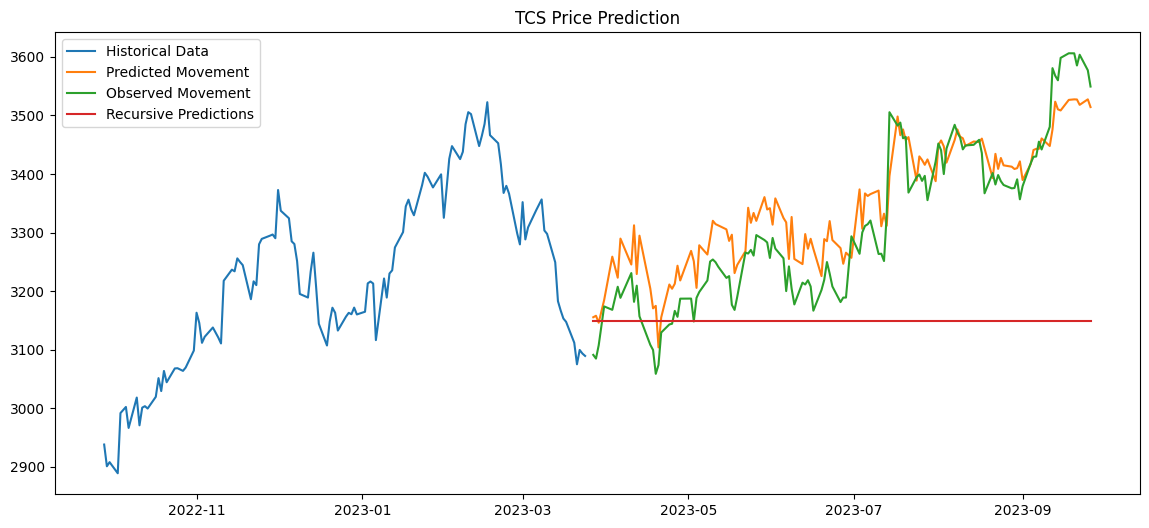

In [92]:
model_prediction('TCS')